In [1]:
pip install mtcnn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN  # MTCNN du package mtcnn
from torchvision import models, transforms
from PIL import Image

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ed/b6/62345568cd07de5d9254fcf64d7e44aacbb6abde11ea953b3cb320e58d19/tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.17.0 from https://files.pythonhosted.org/packages/66/03/5c447feceb72f5a38ac2aa79d306fa5b5772f982c2b480c1329c7e382900/tensorflow_intel-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2db

In [3]:
def load_mtcnn_model():
    mtcnn = MTCNN()
    return mtcnn

In [4]:
def load_inceptionv3_model():
    model = models.inception_v3(pretrained=True)
    model.eval()  # Mettre le modèle en mode évaluation
    return model

In [5]:
def load_image(image_path):
    image = cv2.imread(image_path)
    return image

In [6]:
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [7]:
def preprocess_inceptionv3(face_region):
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    face_tensor = preprocess(face_region).unsqueeze(0)  # Ajouter une dimension batch
    return face_tensor

In [8]:
def extract_embedding_inceptionv3(model, face_region):
    face_tensor = preprocess_inceptionv3(face_region)
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding

In [9]:
def process_image_mtcnn_inceptionv3(image_path):
    image = load_image(image_path)

    # Charger les modèles MTCNN et InceptionV3
    mtcnn = load_mtcnn_model()
    inceptionv3_model = load_inceptionv3_model()

    # Détecter les visages avec MTCNN
    faces = mtcnn.detect_faces(image)

    if len(faces) == 0:
        print("Aucun visage détecté.")
        return

    # Pour chaque visage détecté
    for i, face in enumerate(faces):
        box = face['box']
        x1, y1, width, height = box
        x2, y2 = x1 + width, y1 + height

        # Extraire la région du visage
        face_region = image[y1:y2, x1:x2]
        face_region_pil = Image.fromarray(cv2.cvtColor(face_region, cv2.COLOR_BGR2RGB))

        # Extraire l'embedding avec InceptionV3
        embedding = extract_embedding_inceptionv3(inceptionv3_model, face_region_pil)
        print(f"Embedding généré pour le visage {i+1}: {embedding}")

        # Afficher l'image du visage détecté
        display_image(face_region)

In [56]:
def detect_and_align_face(image):
    """Détecter et aligner les visages"""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = mtcnn.detect_faces(image_rgb)
    
    if len(faces) == 0:
        print("Aucun visage détecté.")
        return None

    face_images = []
    for face in faces:
        x, y, width, height = face['box']
        x1, y1, x2, y2 = x, y, x + width, y + height
        face_region = image_rgb[y1:y2, x1:x2]
        
        # Redimensionner l'image du visage pour InceptionV3 (299x299)
        face_resized = cv2.resize(face_region, (299, 299))
        face_preprocessed = preprocess_input(face_resized.astype('float32'))
        face_images.append(face_preprocessed)
    
    return np.array(face_images)

In [9]:
# def draw_faces_mtcnn(image, faces):
#     # Dessiner des rectangles et les landmarks
#     for face in faces:
#         x, y, width, height = face['box']  # Boîte englobante
#         keypoints = face['keypoints']  # Points de repère
        
#         # Dessiner le rectangle autour du visage
#         cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
        
#         # Dessiner les points de repère (landmarks)
#         cv2.circle(image, (keypoints['left_eye']), 2, (0, 255, 0), 2)
#         cv2.circle(image, (keypoints['right_eye']), 2, (0, 255, 0), 2)
#         cv2.circle(image, (keypoints['nose']), 2, (0, 255, 0), 2)
#         cv2.circle(image, (keypoints['mouth_left']), 2, (0, 255, 0), 2)
#         cv2.circle(image, (keypoints['mouth_right']), 2, (0, 255, 0), 2)

#     return image

In [57]:
def get_embedding(face_pixels):
    """Générer l'embedding pour une image"""
    embedding = model.predict(face_pixels)
    return embedding

In [58]:
def process_image(image_path):
    """Charger, traiter et afficher l'image"""
    image = cv2.imread(image_path)
    
    faces = detect_and_align_face(image)
    if faces is not None:
        for face in faces:
            # Afficher l'image correctement normalisée (en revenant à l'échelle [0, 255])
            face_display = (face - face.min()) / (face.max() - face.min()) * 255
            display_image(face_display)
            
            # Générer l'embedding
            face_pixels = np.expand_dims(face, axis=0)
            embedding = get_embedding(face_pixels)
            print("Embedding généré:", embedding)

In [10]:
image = "C:/Users/mahen/Intranet/Modele_IA/images/profil_picture/selena_profile_picture.jpg"

In [11]:
images = "C:/Users/mahen/Intranet/Modele_IA/images/picture/selena_picture_1.jpg"

C:\Users\mahen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mahen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Embedding généré pour le visage 1: tensor([[ 8.7278e-01, -1.8696e-01, -1.6266e-01, -7.5285e-01, -1.4149e+00,
         -6.4064e-01, -1.4763e+00, -1.1679e-01, -2.3938e-01, -5.9058e-01,
         -2.9303e-02, -1.4957e+00, -9.6603e-01,  2.7794e-01,  4.5372e-01,
         -9.9620e-02, -5.5116e-01, -1.5206e+00, -4.3460e-01, -7.0415e-01,
         -7.5180e-01, -2.6321e-01, -5.1518e-01,  1.7433e-01, -8.9490e-01,
         -7.7991e-01,  5.9465e-01,  2.6306e-01,  4.5134e-02,  4.8295e-01,
         -3.3244e-01, -1.9729e-01,  1.6822e+00, -7.0781e-01, -1.2212e+00,
         -4.4618e-01, -2.2142e-01, -4.0320e-01, -2.0918e-01, -3.3338e-01,
         -3.8417e-01,  7.0477e-02,  3.2066e-01,  6.3186e-01,  2.1271e-01,
         -6.0524e-01, -7.1110e-01,  7.4359e-01,  5.9376e-01, -7.4189e-01,
         -3.3362e-01, -1.5413e-01,  1.6502e+00,  1.0215e-01,  7.2290e-01,
         -2.0182e-02, -6.6437e-01,  2.4926e-01, -1.1249e+00,  8.7533e-01,
         -8.1833e-02,  4.1751e-01,  9.5095e-01,  1.3560e+00,  2.3256e-01,
   

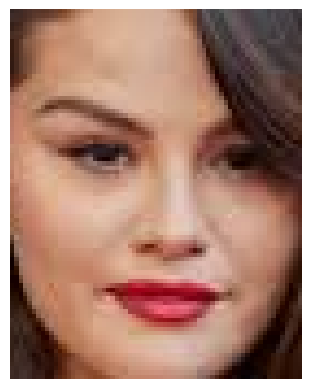

In [12]:
process_image_mtcnn_inceptionv3(image)

Embedding généré pour le visage 1: tensor([[ 1.5410e+00, -4.6733e-01, -1.1781e+00, -1.0922e+00, -6.9022e-01,
         -2.3842e-01, -9.8471e-01, -1.0199e+00, -3.2001e-01, -1.0444e+00,
          1.7102e-01, -1.3826e+00, -1.0497e+00, -1.2890e+00, -9.0448e-01,
         -9.6874e-01, -8.2322e-01, -1.4033e+00, -8.0994e-01, -6.7357e-01,
         -1.4232e+00, -3.2529e-01, -5.6797e-01, -1.1582e+00, -1.3657e+00,
         -5.6363e-01,  4.0148e-01,  5.0147e-01,  1.8396e-01,  1.0369e-02,
         -8.1754e-01, -6.4564e-02,  1.1176e+00, -9.2138e-01, -1.3526e+00,
          2.4393e-01,  7.1512e-01,  3.0020e-01,  4.9875e-01, -7.3524e-01,
         -5.8511e-01,  8.2653e-01, -4.0084e-02,  2.9107e-01,  7.9187e-02,
         -5.3671e-01, -2.6918e-01,  3.0413e-01, -8.8254e-01, -1.3956e+00,
         -4.8674e-01, -5.0377e-01,  9.0283e-02,  3.6722e-01, -7.8428e-02,
         -6.4475e-01, -3.7456e-01, -1.3082e-01, -1.0567e+00,  8.8132e-01,
          2.3074e-01,  1.1727e+00,  8.7660e-01,  6.1245e-01,  2.4481e-01,
   

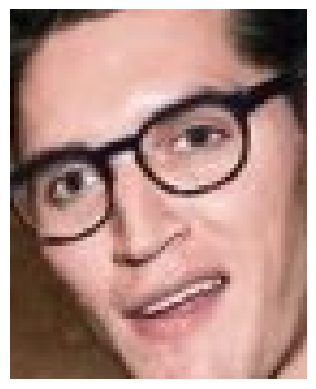

Embedding généré pour le visage 2: tensor([[ 1.5011e+00, -4.8277e-01, -1.2260e+00, -6.2027e-01, -1.4508e+00,
         -4.6409e-01, -7.6717e-01, -4.9162e-01, -1.4491e-02, -2.0008e+00,
          6.4842e-01, -7.6187e-01,  1.0317e-01, -1.2929e+00, -5.9081e-01,
         -1.0552e-01,  3.7428e-01, -7.6062e-01, -6.5601e-01, -5.7142e-01,
         -8.8079e-01, -1.1940e-01, -1.0518e+00, -1.2899e-01, -1.1010e+00,
         -8.8590e-01,  8.3007e-01, -9.2547e-01, -1.7169e-01, -2.2144e-01,
         -1.0320e+00, -5.9788e-01,  1.1292e+00, -2.4925e-01, -1.1313e+00,
         -2.9692e-01,  1.3294e+00,  6.7532e-01,  1.4779e-01, -4.4397e-01,
         -2.6499e-01,  7.4665e-01, -4.1398e-01,  3.4134e-01, -2.3080e-01,
         -3.3553e-01, -7.8012e-01, -1.1769e-01, -2.0671e-01, -1.0615e+00,
         -7.0693e-01, -5.5706e-01, -3.4693e-01, -9.3040e-01, -1.9534e-01,
         -3.4223e-01, -8.8807e-01,  4.2747e-01, -8.8600e-01,  1.1466e+00,
         -4.4267e-01,  9.2205e-01,  2.1980e+00,  1.2494e+00,  9.0327e-01,
   

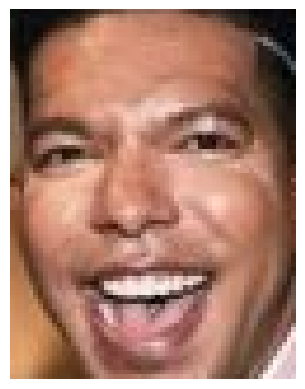

Embedding généré pour le visage 3: tensor([[ 2.5638e+00, -4.5758e-01, -7.3949e-01, -1.3043e+00, -1.9886e+00,
         -8.7026e-01, -1.1461e+00, -3.8024e-01, -1.0546e-02, -1.0515e+00,
          8.6146e-01, -1.3896e+00, -5.8969e-01, -6.3406e-01, -5.2466e-01,
          3.0805e-01, -3.4709e-01, -1.1330e+00, -6.8525e-01, -1.0721e+00,
         -1.4157e+00, -3.7008e-01, -9.1487e-01,  2.7702e-01, -1.2619e+00,
         -1.4735e+00,  3.5928e-01, -5.5615e-01, -2.0284e-01, -2.2799e-01,
         -9.6922e-01, -1.1568e+00,  1.6555e-01, -7.3494e-01, -1.1896e+00,
          2.9630e-01,  6.6447e-01,  2.7660e-01, -4.1985e-02, -1.2046e-01,
         -7.7654e-01,  8.6870e-01, -1.0654e-01,  3.2722e-01, -8.1972e-01,
         -7.9021e-01, -6.1769e-01, -2.7518e-01, -9.3633e-02, -8.5715e-01,
         -2.7088e-01, -3.8938e-01,  4.7619e-02, -5.9246e-01, -2.9306e-01,
         -1.8654e-01, -1.1234e-01,  4.0717e-01, -1.0538e+00,  9.6685e-01,
         -2.1136e-01,  6.7996e-01,  1.5934e+00,  1.4149e+00,  2.9547e-01,
   

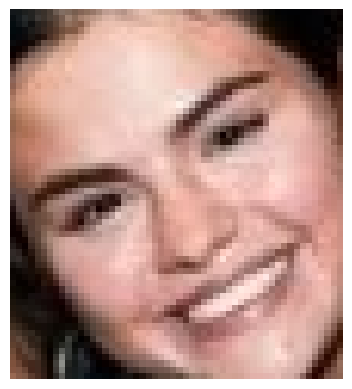

Embedding généré pour le visage 4: tensor([[ 1.4721e+00, -3.1799e-01, -6.9840e-01, -1.2604e+00, -1.4719e+00,
          1.8471e-01, -6.1265e-01, -7.9585e-01, -1.1057e+00, -2.0750e+00,
          7.8071e-01, -8.9426e-01,  3.1335e-01, -1.8536e+00, -1.7174e+00,
         -7.0470e-01, -1.2046e+00, -8.8843e-01, -1.5482e+00, -1.1523e-01,
         -1.3361e+00, -7.3485e-01, -1.9863e+00, -4.9086e-01, -1.3168e+00,
         -1.5234e+00,  7.6736e-02, -9.6269e-01, -7.0692e-01, -1.2002e+00,
          5.6347e-03, -1.1256e+00,  8.7147e-02, -9.8528e-01, -1.1444e+00,
         -2.2195e-01,  3.7067e-01,  3.0707e-01,  1.3341e+00, -7.2310e-01,
         -5.9157e-01,  7.5093e-01, -9.6226e-01,  7.2719e-01, -1.4032e+00,
         -4.4889e-01, -9.8831e-01, -8.6007e-01, -4.2610e-01, -1.7060e+00,
         -8.3212e-01,  5.9260e-01, -1.0923e+00, -8.1501e-01,  5.8505e-02,
         -2.3306e-01, -9.6085e-01, -2.5407e-01, -7.8537e-01,  1.6773e+00,
         -2.1014e-01,  9.8717e-01,  2.8209e+00,  1.6131e+00,  4.7191e-01,
   

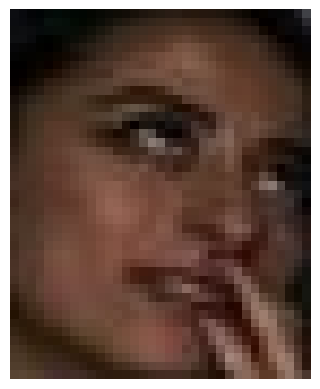

Embedding généré pour le visage 5: tensor([[ 3.6024e+00,  9.1024e-02, -7.7066e-01, -1.6061e+00, -1.2938e+00,
         -9.6176e-01, -1.0772e+00,  4.9243e-01,  5.0030e-01, -5.2958e-01,
          1.9928e-01, -7.5926e-01, -1.4323e-01,  6.1679e-02,  4.6804e-01,
          1.3231e-01, -4.1449e-01, -5.9751e-01, -8.6370e-01, -3.5182e-01,
         -1.4217e+00, -5.8119e-01, -3.6510e-01, -4.4492e-01, -8.5877e-01,
         -1.4835e+00,  4.6180e-01, -1.4824e-01,  5.3512e-01,  2.3678e-01,
         -9.6561e-01, -3.4265e-01,  1.1561e-01, -8.7190e-01, -2.2414e+00,
         -1.8381e-01,  2.6403e-01,  1.0733e+00,  7.3780e-03,  3.1535e-01,
         -9.1290e-01,  9.9300e-02,  4.4461e-01,  2.5425e-01, -7.7895e-01,
         -9.8080e-01,  1.9045e-01, -2.6102e-01, -6.9115e-01, -1.7581e+00,
         -5.6187e-01, -9.1519e-01, -3.5201e-02, -5.2007e-01, -3.8717e-01,
          6.8576e-01, -2.0444e-01,  2.5757e-01, -1.2438e+00,  7.4976e-01,
         -1.1326e+00,  1.3250e+00,  1.1518e+00,  9.6237e-01,  6.7426e-01,
   

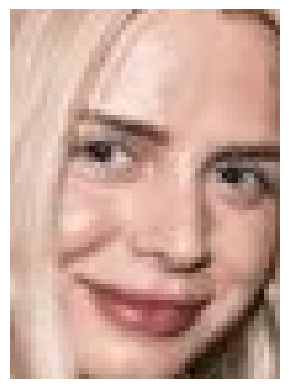

Embedding généré pour le visage 6: tensor([[ 2.8775e+00,  4.4636e-01, -7.1653e-01, -1.5854e+00, -1.7578e+00,
         -2.1050e-01, -1.7073e+00, -4.2998e-01, -1.7317e-01, -1.3702e+00,
          9.7511e-02, -1.1670e+00, -5.8021e-01, -3.7899e-01,  2.3887e-01,
         -2.6944e-01, -4.9195e-01, -3.3609e-02, -5.9925e-01, -4.6883e-01,
         -1.4109e+00, -9.7977e-01,  1.9763e-01,  6.6844e-02, -6.2545e-01,
         -1.4965e+00, -4.8548e-02, -1.0484e+00, -3.0416e-01,  7.7909e-02,
         -1.1833e+00, -7.1302e-01, -8.2920e-02, -5.4520e-01, -1.6827e+00,
         -5.8451e-01,  6.0245e-02,  1.4126e-01, -2.7216e-01, -8.2817e-01,
         -6.2256e-01, -2.3671e-01, -5.5357e-01,  1.7606e-01, -1.1636e+00,
         -8.4481e-01, -7.5820e-01,  1.5542e-01, -3.8710e-01, -1.9121e+00,
         -6.8497e-01, -1.1667e-01, -3.8779e-02, -6.0912e-01, -1.0469e+00,
         -1.5204e-02, -1.0403e+00,  1.8274e-01, -1.0525e+00,  7.7332e-01,
         -9.2387e-01,  1.4834e-02,  4.9603e-01,  5.5900e-01,  3.6996e-01,
   

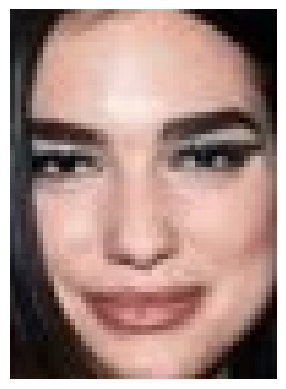

In [13]:
process_image_mtcnn_inceptionv3(images)